In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Voting classifier

<img src=http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier_files/majority_voting.png width=400/>

</br>

**Метод простого голосования**
* $c_1, c_2, ..., c_m$ - обученные алгоритмы  
* Классификация: относим $x$ к классу, за который проголосовало *большинство* из $c_1(x), c_2(x), ..., c_m(x)$
* Регрессия: ответом является среднее значение $c_1(x), c_2(x), ..., c_m(x)$



In [2]:
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=1000, centers=[[-2, 1], [0, -2]], cluster_std=1)
X2, y2 = make_blobs(n_samples=500, centers=[[3, 0], [1, 3]], cluster_std=1)
X = np.concatenate([X1, X2])
y = np.concatenate([y1, y2])

<ipython-input-3-c5b81ec59489>:7: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  ax.scatter(x[reds, 0], x[reds, 1], c="red", s=80, edgecolor="K")


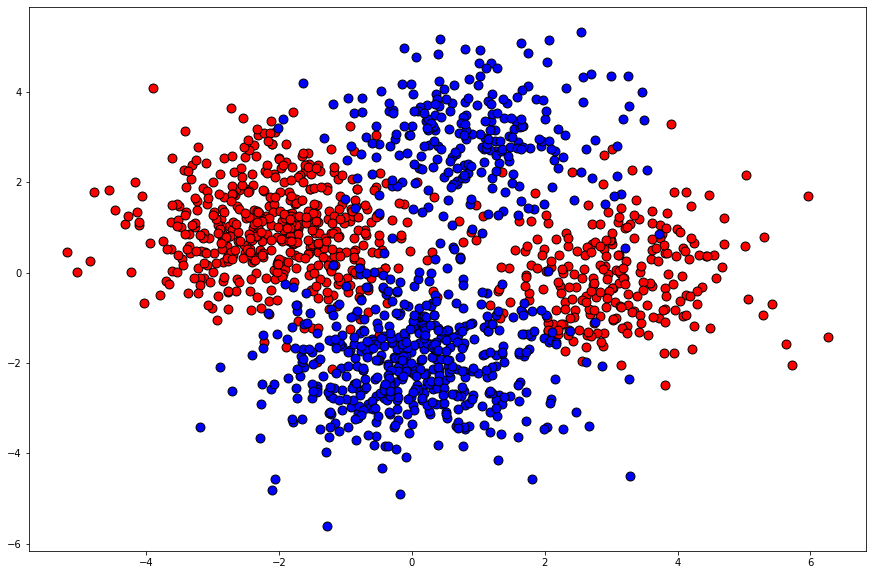

In [3]:
def plot_blobs(x, y):

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    reds = y == 0
    blues = y == 1
    
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=80, edgecolor="K")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=80, edgecolor="K")

    plt.show()

plot_blobs(X, y)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
X_train.shape, X_test.shape

((1050, 2), (450, 2))

## Логистическая регрессия

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_pred)

array([[138, 104],
       [ 63, 145]])

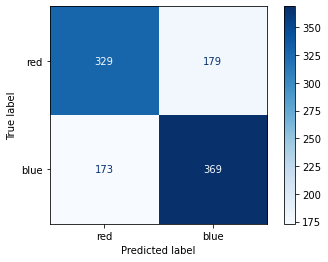

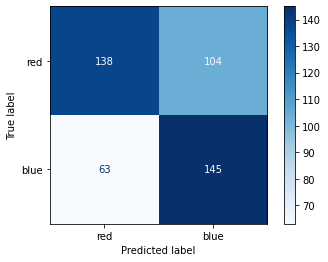

In [8]:
def plot_confusion(model, X, y, class_names=('red', 'blue')):
    ConfusionMatrixDisplay.from_estimator(model, X, y, cmap=plt.cm.Blues, display_labels=class_names, values_format='d')
plot_confusion(lr, X_train, y_train)
plot_confusion(lr, X_test, y_test)

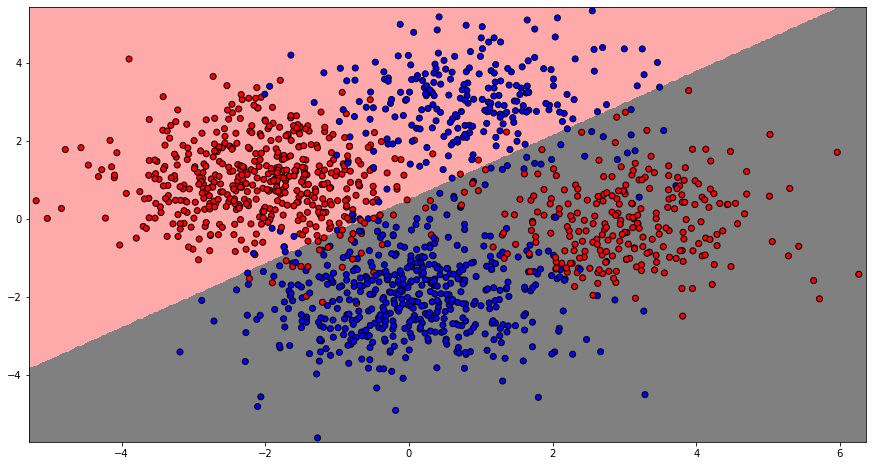

In [9]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def plot_blob_classes(model, X, y):
    plt.figure(figsize=(15,8))

    eps = 0.1
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                         np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))

    colors = ("red", "blue")
    colored_y = np.zeros(y.size, dtype=str)

    for i, cl in enumerate([0,1]):
        colored_y[y == cl] = str(colors[i])

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', 'grey'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=colored_y, edgecolors='K')
    plt.show()

plot_blob_classes(lr, X, y)

In [10]:
lr.score(X_test, y_test)

0.6288888888888889

## Дерево решений

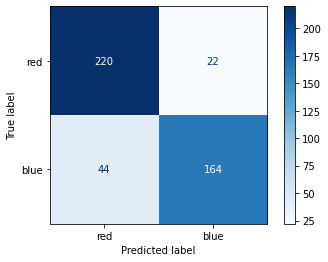

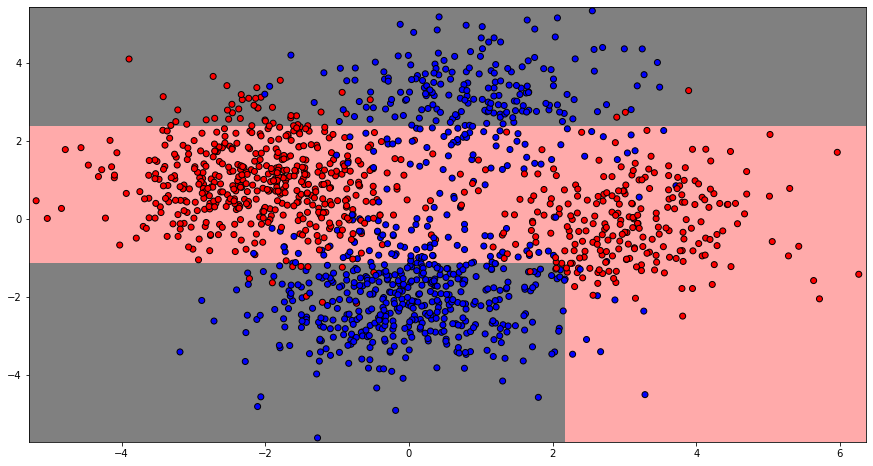

0.8533333333333334

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
plot_confusion(dt, X_test, y_test)
plot_blob_classes(dt, X, y)
dt.score(X_test, y_test)

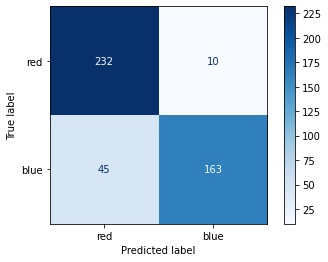

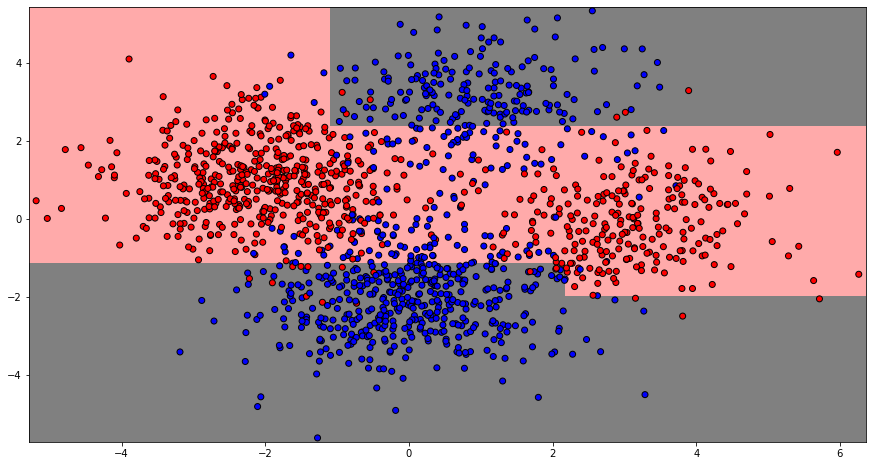

0.8777777777777778

In [12]:
dt3 = DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)
plot_confusion(dt3, X_test, y_test)
plot_blob_classes(dt3, X, y)
dt3.score(X_test, y_test)

## K-NN 

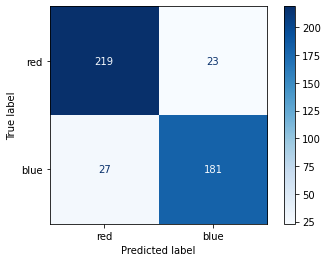

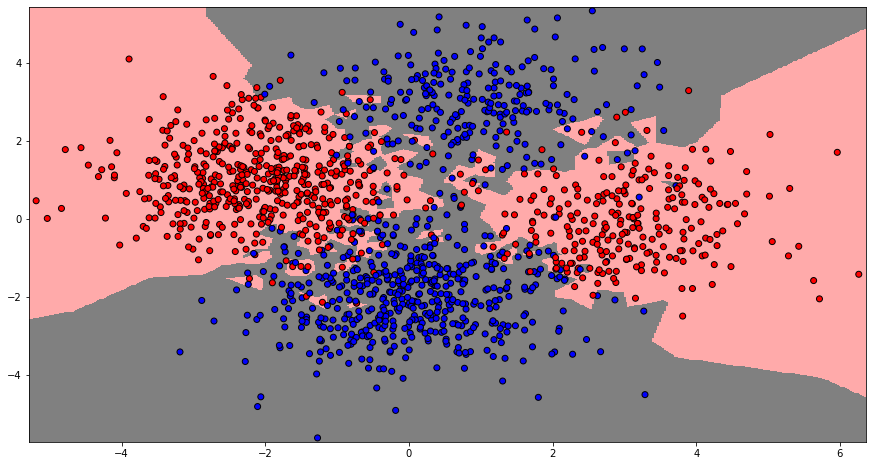

0.8888888888888888

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
plot_confusion(knn, X_test, y_test)
plot_blob_classes(knn, X, y)

knn.score(X_test, y_test)

## Наивный байесовский классификатор

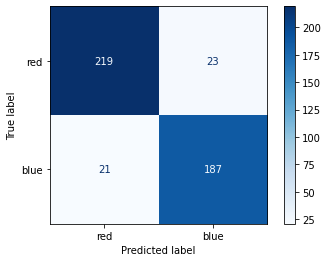

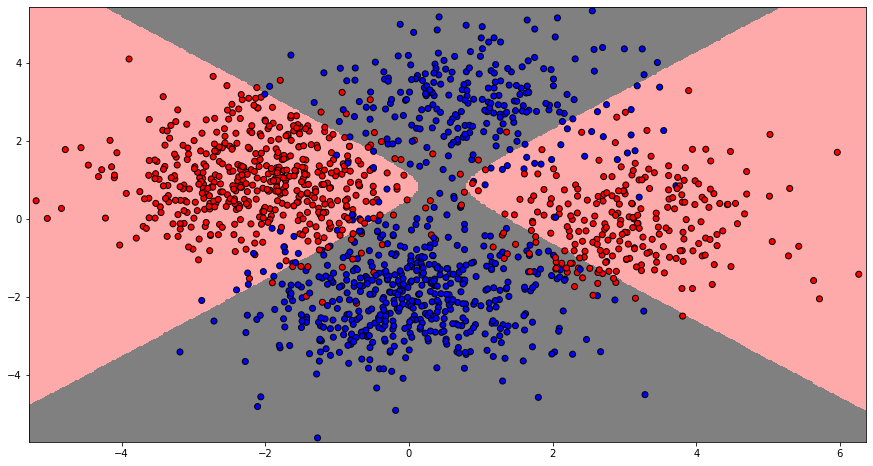

0.9022222222222223

In [14]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
plot_confusion(gnb, X_test, y_test)
plot_blob_classes(gnb, X, y)
gnb.score(X_test, y_test)

## Voting classifier

In [15]:
classifiers = [('lr', lr), ('dt2', dt), ('dt3', dt3), ('knn', knn), ('gnb', gnb)]
classifiers

[('lr', LogisticRegression()),
 ('dt2', DecisionTreeClassifier(max_depth=2)),
 ('dt3', DecisionTreeClassifier(max_depth=3)),
 ('knn', KNeighborsClassifier(n_neighbors=1)),
 ('gnb', GaussianNB())]

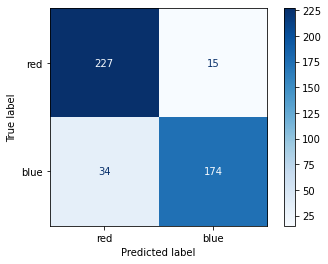

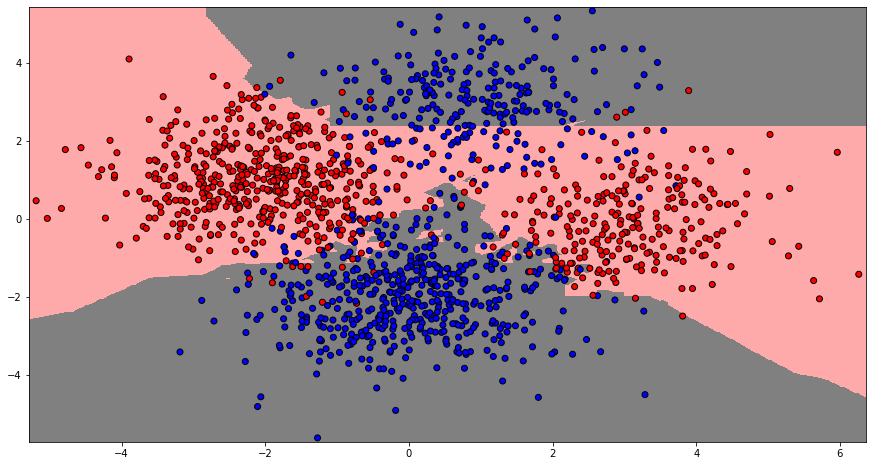

0.8911111111111111

In [16]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=classifiers, voting='hard')
vc.fit(X_train, y_train)
plot_confusion(vc, X_test, y_test)
plot_blob_classes(vc, X, y)
vc.score(X_test, y_test)

In [17]:
params = {'lr__C' : [0.5, 1, 1.5], 
          'lr__class_weight': [None,'balanced'],
          'dt2__max_depth' : np.arange(1, 6),
          'dt3__max_depth' : np.arange(1, 6),
          'knn__n_neighbors' : np.arange(1, 20),
          'voting' : ['hard', 'soft']} 
np.prod([len(v) for k, v in params.items()])

5700

In [18]:
%%time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
optimal = RandomizedSearchCV(estimator=vc, param_distributions=params, n_iter=500, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)

CPU times: user 4.32 s, sys: 158 ms, total: 4.48 s
Wall time: 31.9 s


In [19]:
optimal.best_params_

{'voting': 'soft',
 'lr__class_weight': 'balanced',
 'lr__C': 0.5,
 'knn__n_neighbors': 17,
 'dt3__max_depth': 4,
 'dt2__max_depth': 4}

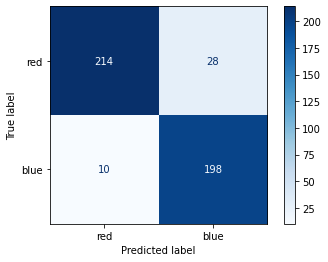

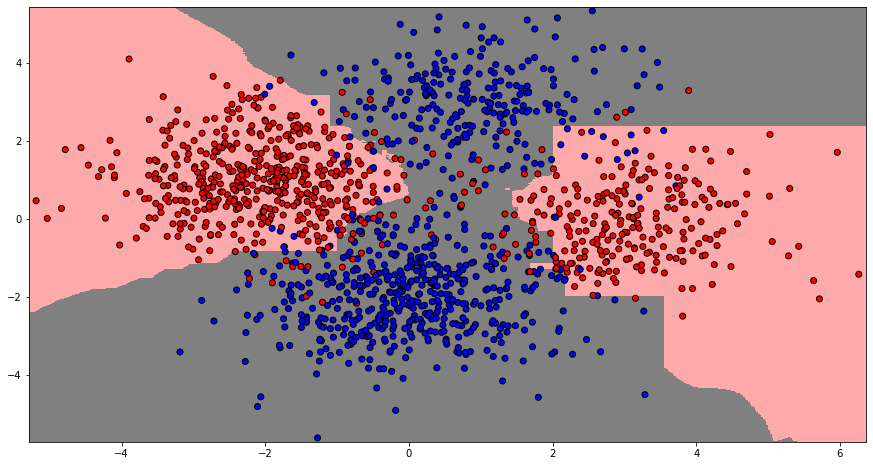

0.9155555555555556

In [20]:
plot_confusion(optimal, X_test, y_test)
plot_blob_classes(optimal, X, y)
optimal.score(X_test, y_test)

# Случайный лес


**Бутстрэп**  
<img src=https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/Bagging.png width=700/>

</br>

<image src=https://всеответы.рф/wp-content/uploads/2020/03/Random-forest.jpg width=800 />

## Пятна

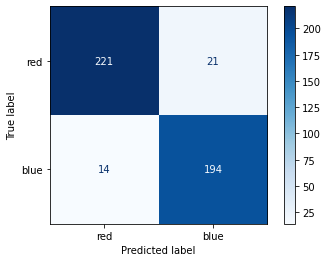

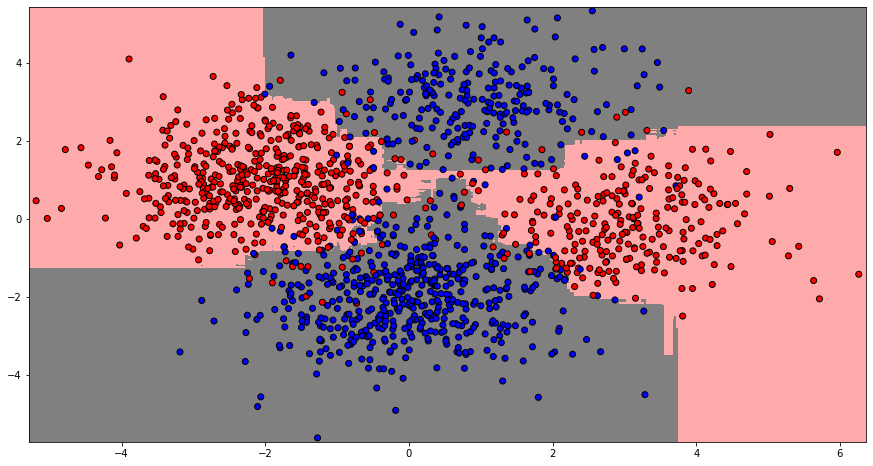

0.9222222222222223

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_split=10).fit(X_train, y_train)
plot_confusion(rf, X_test, y_test)
plot_blob_classes(rf, X, y)
rf.score(X_test, y_test)

## Титаник

In [22]:
!wget -c https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
!ls

--2023-01-09 10:47:47--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.02s   

2023-01-09 10:47:48 (2.04 MB/s) - ‘titanic.csv’ saved [44225/44225]

sample_data  titanic.csv


In [23]:
df = pd.read_csv('titanic.csv')
df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [24]:
yt = df.Survived.values
Xt = df.drop(['Name', 'Survived'], axis=1)
Xt.sample(5)

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
769,3,male,29.0,0,0,7.225
857,2,male,21.0,1,0,11.500
821,3,male,36.0,0,0,6.950
634,2,male,31.0,1,1,26.250
616,2,male,26.0,0,0,10.500


In [25]:
Xt['Sex'].unique()

array(['male', 'female'], dtype=object)

In [26]:
categories = {'female' : 1, 'male' : 0}
Xt['Sex'] = Xt['Sex'].map(categories)
Xt.sample(5)

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
850,2,1,44.0,1,0,26.0000
596,1,0,49.0,1,0,56.9292
223,1,0,38.0,1,0,90.0000
400,3,1,21.0,1,0,9.8250
191,3,1,19.0,1,0,7.8542


In [27]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.25)

In [28]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(Xt_train, yt_train)

CPU times: user 169 ms, sys: 4.9 ms, total: 174 ms
Wall time: 176 ms


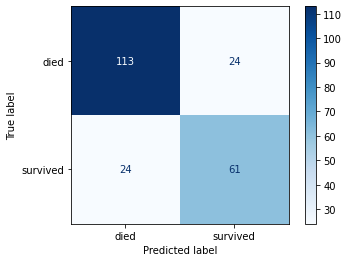

In [29]:
plot_confusion(rf, Xt_test, yt_test, class_names=['died', 'survived'])

In [30]:
rf.score(Xt_test, yt_test)

0.7837837837837838

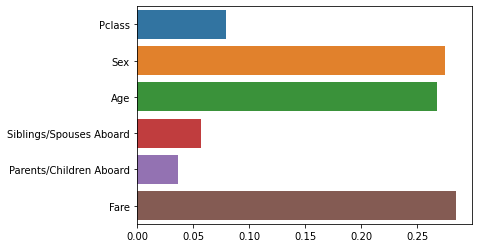

In [31]:
sns.barplot(x=rf.feature_importances_, y=Xt_train.columns)

#Boosting
<image src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Ensemble_Boosting.svg" alt="boosting diagram" width=800/>

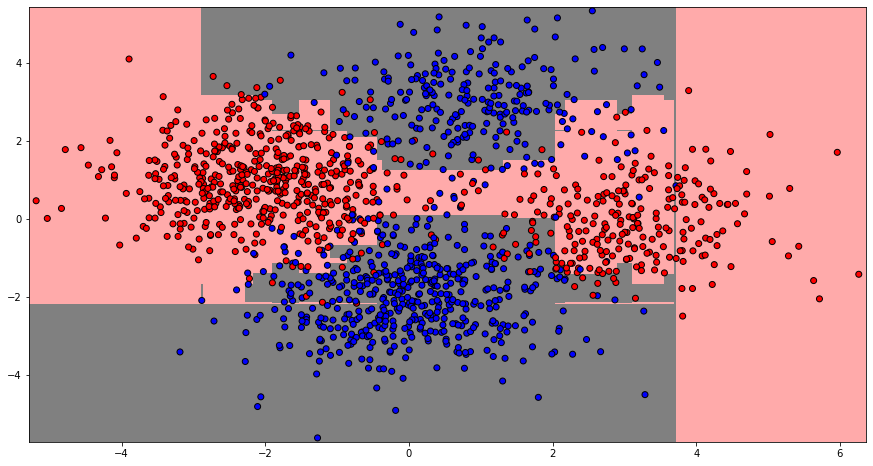

0.8888888888888888

In [32]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier().fit(X_train, y_train)
plot_blob_classes(ab, X, y)
ab.score(X_test, y_test)

0.7837837837837838

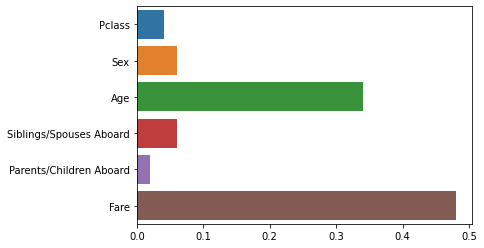

In [33]:
ab = AdaBoostClassifier().fit(Xt_train, yt_train)
sns.barplot(x=ab.feature_importances_, y=Xt_train.columns)
ab.score(Xt_test, yt_test)

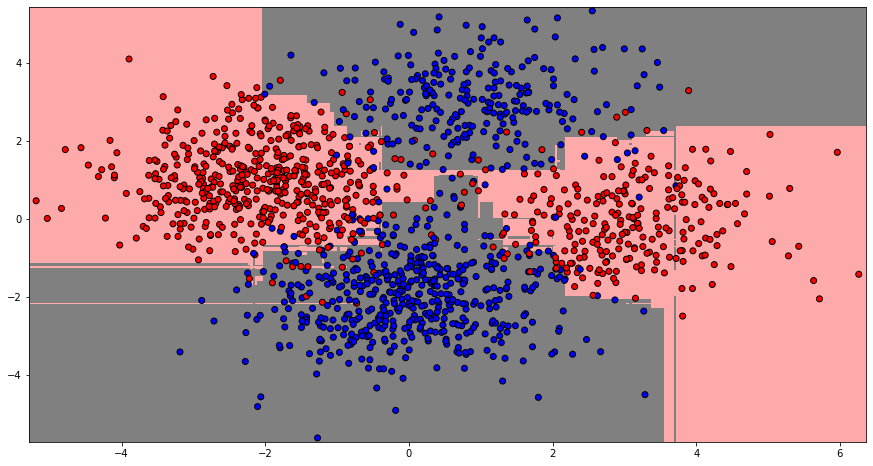

0.9222222222222223

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier().fit(X_train, y_train)
plot_blob_classes(gb, X, y)
gb.score(X_test, y_test)

0.8108108108108109

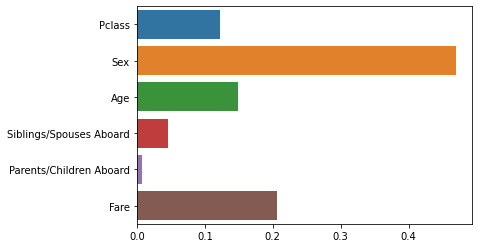

In [35]:
gb = GradientBoostingClassifier().fit(Xt_train, yt_train)
sns.barplot(x=gb.feature_importances_, y=Xt_train.columns)
gb.score(Xt_test, yt_test)

# Перцептрон

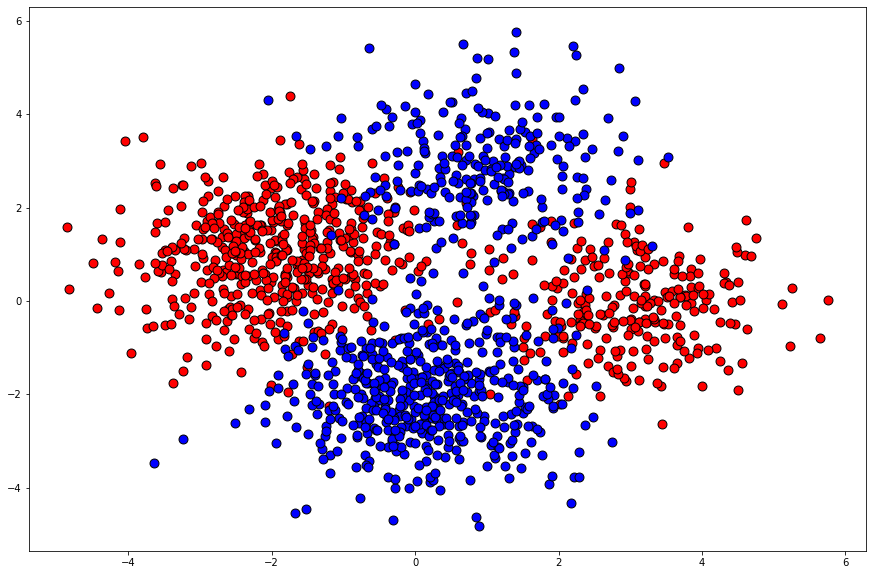

((1200, 2), (1200,), (300, 2), (300,))

In [36]:
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=1000, centers=[[-2, 1], [0, -2]], cluster_std=1)
X2, y2 = make_blobs(n_samples=500, centers=[[3, 0], [1, 3]], cluster_std=1)
X = np.concatenate([X1, X2])
y = np.concatenate([y1, y2])
plot_blobs(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

## Keras

[Keras](https://keras.io/) — библиотека, предоставляющая высокоуровневые cтроительные блоки для конструирования моделей глубокого обучения.  

|![Keras](https://www.digikey.com/maker-media/6c3d4f5f-98e0-4104-ad8c-fb0b47000109 "Title")|
|:-------------------------------:|
| Source: https://www.digikey.com/maker-media/6c3d4f5f-98e0-4104-ad8c-fb0b47000109 |

### Определение модели

Модель можно определить двумя способами:   
1. с использованием класса Sequential (только для линейного стека слоев) 
2. с помощью функционального API (для ориентированного ациклического графа слоев, позволяющего конструировать произвольные архитектуры). Функциональный API позволяет манипулировать данными в тензорах, которые обрабатывает модель, и применять слои к этим тензорам, как если бы они были функциями.

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [38]:
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(4, activation='elu'))
model.add(Dense(4, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [39]:
# input_tensor = Input(shape=(2,))
# d1 = Dense(4, activation='elu')(input_tensor)
# d2 = Dense(4, activation='elu')(d1)
# output_tensor = Dense(1, activation='sigmoid')(d2)

# model = Model(inputs=input_tensor, outputs=output_tensor)
# model.summary()

In [40]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

### Обучение модели

Процесс обучения состоит в передаче массивов Numpy с входными данными (и соответствующими целевыми данными) в метод fit()

Сеть перебирает обучающие данные пакетами по 32 образца. Для каждого пакета сеть вычисляет градиенты весов с учетом потерь в пакете и изменяет значения весов в соответствующем направлении.

Можно разделить полный датасет из 1200 объектов на батчи размером 400 объектов. Таким образом, для завершения одной эпохи потребуется 3 итерации.


In [41]:
from tensorflow.keras.callbacks import EarlyStopping

results = model.fit(X_train, 
                    y_train,
                    batch_size=1200,
                    epochs=200000,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             restore_best_weights=True)]
                    )

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 49ms/step - loss: 0.1698 - binary_accuracy: 0.9281 - val_loss: 0.1416 - val_binary_accuracy: 0.9542
Epoch 5676/200000
1/1 [==============================] - 0s 50ms/step - loss: 0.1698 - binary_accuracy: 0.9281 - val_loss: 0.1416 - val_binary_accuracy: 0.9542
Epoch 5677/200000
1/1 [==============================] - 0s 35ms/step - loss: 0.1698 - binary_accuracy: 0.9281 - val_loss: 0.1416 - val_binary_accuracy: 0.9542
Epoch 5678/200000
1/1 [==============================] - 0s 35ms/step - loss: 0.1698 - binary_accuracy: 0.9281 - val_loss: 0.1416 - val_binary_accuracy: 0.9542
Epoch 5679/200000
1/1 [==============================] - 0s 34ms/step - loss: 0.1698 - binary_accuracy: 0.9281 - val_loss: 0.1416 - val_binary_accuracy: 0.9542
Epoch 5680/200000
1/1 [==============================] - 0s 35ms/step - loss: 0.1698 - binary_accuracy: 0.9281 - val_loss: 0.1416 - val_binary_accurac

### Объект history

Вызов `model.fit()` возвращает объект History. Этот объект имеет поле *history* - словарь со значениями функции потерь и метрики 

In [42]:
results

In [43]:
results.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [44]:
hist = pd.DataFrame(results.history)
hist

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,1.480409,0.397917,1.519871,0.366667
1,1.473054,0.396875,1.512494,0.366667
2,1.465735,0.396875,1.505152,0.366667
3,1.458453,0.396875,1.497846,0.366667
4,1.451207,0.396875,1.490577,0.362500
...,...,...,...,...
8169,0.167660,0.929167,0.137795,0.958333
8170,0.167659,0.929167,0.137795,0.958333
8171,0.167658,0.929167,0.137795,0.958333
8172,0.167657,0.929167,0.137795,0.958333


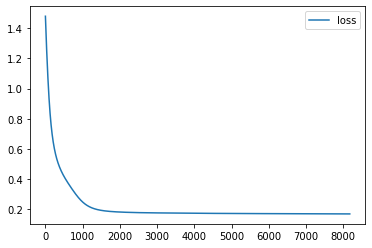

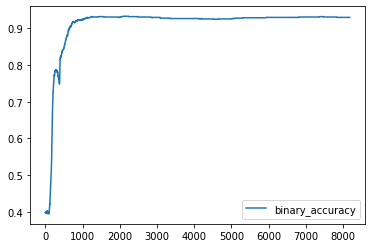

In [45]:
hist[['loss']].plot()
hist[['binary_accuracy']].plot()

In [46]:
loss, acc = model.evaluate(X_test, y_test, batch_size=300)
print('Test loss:', loss)
print('Test accuracy:', acc)

1/1 [==============================] - 0s 27ms/step - loss: 0.1707 - binary_accuracy: 0.9367
Test loss: 0.17070698738098145
Test accuracy: 0.9366666674613953


7813/7813 [==============================] - 14s 2ms/step


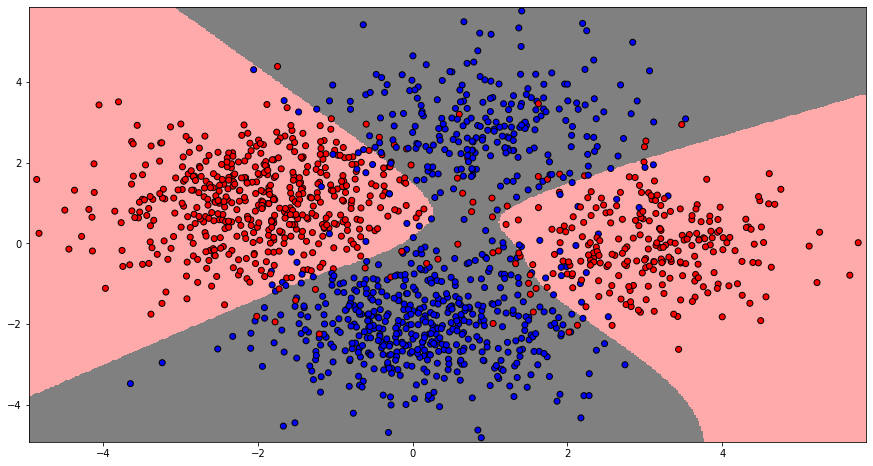

In [47]:
plot_blob_classes(model, X, y)

# Задание

1. Применить один из бустовых классификаторов к своему датасету, кроссвалидацией оценить accuracy. Как она соотносится с accuracy из задания к семинару 3?
2. Визуализировать оценку важности признаков в обученном классификаторе.

1

In [48]:
df_test = pd.read_csv('/content/sample_data/NBA_2020.csv')
df_train = pd.read_csv('/content/sample_data/NBA_2021.csv')
df_test = df_test.applymap(lambda x: x if pd.notnull(x) else 0)
df_train = df_train.applymap(lambda x: x if pd.notnull(x) else 0)
df_train

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,0.544,...,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0
1,Jaylen Adams,PG,24,MIL,7,0,2.6,0.1,1.1,0.125,...,0.000,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3
2,Steven Adams,C,27,NOP,58,58,27.7,3.3,5.3,0.614,...,0.444,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6
3,Bam Adebayo,C,23,MIA,64,64,33.5,7.1,12.5,0.570,...,0.799,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7
4,LaMarcus Aldridge,C,35,TOT,26,23,25.9,5.4,11.4,0.473,...,0.872,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,Myles Turner,C,24,IND,47,47,31.0,4.4,9.2,0.477,...,0.782,1.3,5.2,6.5,1.0,0.9,3.4,1.4,3.5,12.6
647,Jonas Valan?i?nas,C,28,MEM,62,61,28.3,7.1,12.0,0.592,...,0.773,4.1,8.4,12.5,1.8,0.6,0.9,1.6,2.9,17.1
648,Denzel Valentine,SG,27,CHI,62,3,16.7,2.5,6.7,0.373,...,0.941,0.4,2.8,3.2,1.7,0.5,0.1,0.7,1.1,6.5
649,Jarred Vanderbilt,PF,21,MIN,64,30,17.8,2.2,3.7,0.606,...,0.559,1.8,3.9,5.8,1.2,1.0,0.7,0.8,1.9,5.4


In [49]:
col = ['G', 'GS', 'FG%', 'FT%', '3P%', '2P', '2PA', 'eFG%', 'FT', 'ORB', 'TOV', 'TRB', 'BLK', 'PTS']

X_train = df_train[col].values
Y_train = df_train['DRB'].apply(lambda x: x > 2.5).values

X_test = df_test[col].values
Y_test = df_test['DRB'].apply(lambda x: x > 2.5).values

In [50]:
ab = AdaBoostClassifier().fit(X_train, Y_train)
ab.score(X_train, Y_train)

1.0

2

In [51]:
ab.score(X_test, Y_test)

0.9815668202764977

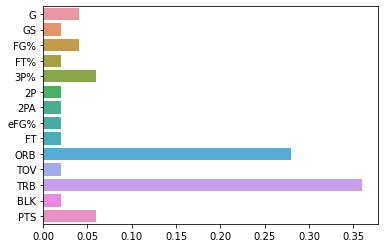

In [52]:
sns.barplot(x=ab.feature_importances_, y=col)